In [7]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"

from matplotlib.pyplot import figure
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
import cobra

In [8]:
# define functions for the estiamting delta G ranges
RT = 8.31446261815324 * 10**-3 * 298.15

def parse_reaction_to_df(reaction):
    mdf = {'met_id': [], 'met_id_full':[],'s': [] }
    for met in reaction.metabolites:
        mdf['s'].append(reaction.metabolites[met])
        ##mdf['met_id'].append(met.id.split('_')[0])
        mdf['met_id'].append(met.id[:-2])
        mdf['met_id_full'].append(met.id)
    
    mdf = pd.DataFrame(mdf)
    mdf['met_id'] = mdf['met_id'].apply(lambda x: 'bigg.metabolite:' + x)
    return mdf


def get_concentrations(x,metConc):
    if x == 'bigg.metabolite:nad':
        return 2.6e-3
    elif x == 'bigg.metabolite:nadh':
        return 8.3e-5
    elif x == 'bigg.metabolite:nadp':
        return 2.1e-6
    elif x == 'bigg.metabolite:nadph':
        return 1.2e-4
    elif x in ['bigg.metabolite:h','bigg.metabolite:h2o']:
        return 1
    else:
        return metConc
    
    
def rdf2metConcs(mdf,ub,lb):
    maxG_conc = []
    minG_conc = []
    met_lb = lb;
    met_ub = ub;

    for i,row in mdf.iterrows():
        if row.s < 0:
            minG_conc.append(get_concentrations(row.met_id,met_ub))
            maxG_conc.append(get_concentrations(row.met_id,met_lb))
        else:
            minG_conc.append(get_concentrations(row.met_id,met_lb))
            maxG_conc.append(get_concentrations(row.met_id,met_ub))

    mdf['conc_maxG'] =  maxG_conc;
    mdf['conc_minG'] =  minG_conc;
    return mdf

def dg2dir(maxDg,minDg):
    if (maxDg > 0) & (minDg < 0):
        return 'reversible'
    elif (maxDg > 0) & (minDg > 0):
        return 'irreversible (backward)'
    else:
        return 'irreversible (forward)'
    
def append_gene_set_with_free_energy_range(model,dfff,lb,ub):

    wt_coenzyme = []
    mut_coenzyme = []

    wt_max_dg = []
    wt_min_dg = []

    mut_max_dg = []
    mut_min_dg = []

    for idx,row in dfff.iterrows():
        rsub = [x for x in model.reactions if row.reaction == x.id][0]
        mdf = parse_reaction_to_df(rsub)
        mdf_mut = mdf.copy()
        if 'bigg.metabolite:nadph' in mdf['met_id'].tolist():
            wt_coenzyme.append('NADP(H)')
            mut_coenzyme.append('NAD(H)')
            mdf_mut['met_id'] = mdf_mut.met_id.replace({'bigg.metabolite:nadph': 'bigg.metabolite:nadh', 'bigg.metabolite:nadp': 'bigg.metabolite:nad'})
        else:
            wt_coenzyme.append('NAD(H)')
            mut_coenzyme.append('NADP(H)')
            mdf_mut['met_id'] = mdf_mut.met_id.replace({'bigg.metabolite:nadh': 'bigg.metabolite:nadph', 'bigg.metabolite:nad': 'bigg.metabolite:nadp'})

        mdf = rdf2metConcs(mdf,ub,lb)
        mdf_mut = rdf2metConcs(mdf_mut,ub,lb)
        wt_max_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf['conc_maxG'] ** mdf['s'])))
        wt_min_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf['conc_minG'] ** mdf['s'])))

        mut_max_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf_mut['conc_maxG'] ** mdf_mut['s'])))
        mut_min_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf_mut['conc_minG'] ** mdf_mut['s'])))
        
    dfff['wild type coenzyme'] = wt_coenzyme
    dfff['mutant coenzyme'] = mut_coenzyme

    dfff['max_deltaG (WT)'] = wt_max_dg
    dfff['min_deltaG (WT)'] = wt_min_dg

    dfff['max_deltaG (mutant)'] = mut_max_dg
    dfff['min_deltaG (mutant)'] = mut_min_dg
        
    mut_dir  = [];
    wt_dir = []
    for idx,row in dfff.iterrows():
        wt_dir.append(dg2dir(row['max_deltaG (WT)'],row['min_deltaG (WT)']))
        mut_dir.append(dg2dir(row['max_deltaG (mutant)'],row['min_deltaG (mutant)']))

    dfff['direction (wild type)'] = wt_dir
    dfff['direction (mutant)'] = mut_dir
    return dfff


def swap_reaction(model,reaction_index,thermo):
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = model.reactions[reaction_index].copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}

    v2 = {}
    for x,y in v.items():
        if x.id == 'nadph_c':
            v2[met_objs['nadh']] = y
        elif x.id == 'nadp_c':
            v2[met_objs['nad']] = y
        elif x.id == 'nadh_c':
            v2[met_objs['nadph']] = y
        elif x.id == 'nad_c':
            v2[met_objs['nadp']] = y
            
    rxn.subtract_metabolites(v)
    rxn.add_metabolites(v2)
    rxn.id = rxn.id + '[mutant]'
    if thermo == 'irreversible (forward)':
        rxn.lower_bound = 0;rxn.upper_bound = 1000;
    elif thermo == 'irreversible (backward)':
        rxn.lower_bound = -1000;rxn.upper_bound = 0;
    elif thermo == 'reversible':
        rxn.lower_bound = -1000;rxn.upper_bound = 1000;
    
        
    model.remove_reactions(m.reactions[reaction_index])
    model.add_reaction(rxn)
    return model

In [9]:
df = pd.read_hdf('../scc/growthRates.rxnBounds.hdf','df')

In [10]:
# only keep WT growth rates
#df = df.fillna(0)
df = df.clip(0)
wt_conds = [x for x in list(df) if x.split('_')[-1] == 'R']
df_err = df[(df[wt_conds] == 0).T.sum() == 0]

In [11]:
frac = (df_err < 1e-9).sum() / len(df_err)
frac = pd.DataFrame(frac,columns=['lethal fraction'])

In [12]:
frac['reaction'] = [x.split('_')[0] for x in frac.index.get_level_values(0)]
frac['coenzyme'] = [x.split('_')[1] for x in frac.index.get_level_values(0)]
frac['direction'] = [x.split('_')[2] for x in frac.index.get_level_values(0)]

In [13]:
fr = frac[frac['direction'].isin(['F','B'])]

In [14]:
#sns.catplot(y='lethal fraction',x='reaction',hue='coenzyme',data=fr)

In [15]:
frr = fr.pivot_table(index='reaction',columns = ['coenzyme','direction'],values='lethal fraction' )

In [16]:
frr

coenzyme        NAD                NADP          
direction         B         F         B         F
reaction                                         
5DGLCNR    0.000109  0.000000  0.000109  0.000000
ABUTD      0.000000  0.000000  0.000000  0.000000
AGPR       0.000000  0.961217  0.000000  0.961217
AKGDH      0.000000  0.000000  0.000000  0.000000
ALCD19     0.000109  0.000000  0.000109  0.000000
...             ...       ...       ...       ...
UAPGR      0.995378  0.000000  0.995378  0.000000
UDPGD      0.000000  0.000000  0.000000  0.000000
UDPGDC     0.000000  0.000000  0.000000  0.000000
URDGLYCD   0.000000  0.000000  0.000000  0.000000
XAND       0.045657  0.000000  0.045657  0.000000

[95 rows x 4 columns]

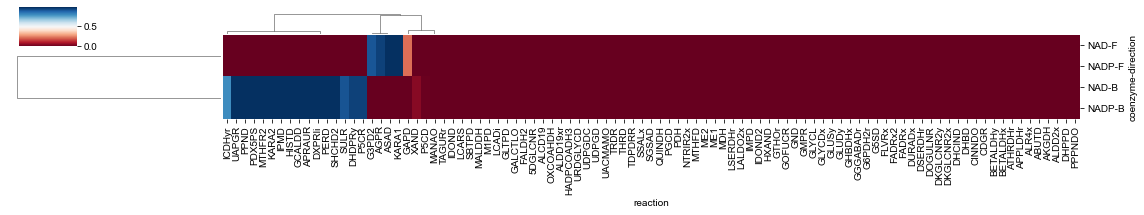

In [12]:
#rmap = {'NAD': 'r', 'NADP': 'b'}
#row_colors = frr.T.index.get_level_values(0).map(rmap)

sns.clustermap(frr.T,figsize =(16,3),cmap='RdBu',xticklabels=True)
#plt.yticks(rotation=90)


In [17]:
model = cobra.io.read_sbml_model('../assets/iJO1366.xml')
mets_model = [x.id for x in model.metabolites]

In [18]:
#met_conc = pd.read_csv('../assets/metabolite_abundances/ecoli_met_concs_Park_NatChemBio_2016.csv')
#met_conc['met_id'] = met_conc['met'].apply(lambda x: x.replace(']','').replace('[','_').replace('-','__'))
#m = met_conc[met_conc['conc_lb'] > 0]

In [19]:
met_conc = pd.read_csv('../assets/metabolite_concs.csv')
rxn_dg = pd.read_csv('../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')

In [20]:
rxns = frr.index.get_level_values(0).tolist()

In [21]:
# compute probability of backward or forward flux using metabolite concentration sampling

NumSims = 1000
p_forward = []
p_reverse = []
coenzyme = []
rns = []
wt = []

for idx,row in rxn_dg.iterrows():
    rsub = [x for x in model.reactions if x.id == row.reaction][0].copy()
    rdf = parse_reaction_to_df(rsub)
    rdf.columns = ['eq_id','id','s']
    #rdf['met'] = [x.split(':')[1] for x in rdf.met_id]
    # np.random.rand(1)[0]
    rdf_mc = rdf.set_index('id').join(met_conc.set_index('met_id'))
    rdf_mc['conc_lb'] = rdf_mc['conc_lb'].fillna(1e-9)
    rdf_mc['conc_ub'] = rdf_mc['conc_ub'].fillna(0.1)
    directions = []
    for i in range(0,NumSims):
        u = np.random.rand(len(rdf_mc))
        rdf_mc['u'] = u
        rdf_mc['sample'] = 10**((np.log10(rdf_mc['conc_ub']) - np.log10(rdf_mc['conc_lb']))*u + np.log10(rdf_mc['conc_lb']))
        dgg = RT*sum(rdf_mc['sample'].apply(np.log) * rdf_mc['s'])
        deltaG = row['deltaG_prime_m'] + dgg
        if deltaG < 0:
            directions.append(1)
        else:
            directions.append(-1)
            
    # compute probability of forward reaction
    p_forward.append(sum(np.array(directions)==1)/len(directions))
    p_reverse.append(sum(np.array(directions)==-1)/len(directions))


    if 'nadph_c' in rdf.id.tolist():
        rdfm = rdf.copy(); rdfm['id'] = rdfm.id.replace({'nadph_c':'nadh_c','nadp_c':'nad_c'})
        coenzyme.append('NADP');coenzyme.append('NAD');
        wt.append('NADP'); wt.append('NADP')
    else:
        rdfm = rdf.copy(); rdfm['id'] = rdfm.id.replace({'nadh_c':'nadph_c','nad_c':'nadp_c'})
        coenzyme.append('NAD');coenzyme.append('NADP');
        wt.append('NAD'); wt.append('NAD')
    
    rdf_mc = rdfm.set_index('id').join(met_conc.set_index('met_id'))
    rdf_mc['conc_lb'] = rdf_mc['conc_lb'].fillna(1e-9)
    rdf_mc['conc_ub'] = rdf_mc['conc_ub'].fillna(0.1)
    directions = []
    for i in range(0,NumSims):
        u = np.random.rand(len(rdf_mc))
        rdf_mc['u'] = u
        rdf_mc['sample'] = 10**((np.log10(rdf_mc['conc_ub']) - np.log10(rdf_mc['conc_lb']))*u + np.log10(rdf_mc['conc_lb']))
        dgg = RT*sum(rdf_mc['sample'].apply(np.log) * rdf_mc['s'])
        deltaG = row['deltaG_prime_m'] + dgg
        if deltaG < 0:
            directions.append(1)
        else:
            directions.append(-1)
            
    p_forward.append(sum(np.array(directions)==1)/len(directions))
    p_reverse.append(sum(np.array(directions)==-1)/len(directions))
    rns.append(row.reaction);
    rns.append(row.reaction);
    
prob_dirs = pd.DataFrame({'reactions': rns, 'wt_coenzyme':wt, 'coenzyme': coenzyme, 'p_forward': p_forward, 'p_reverse': p_reverse})

In [24]:
prob_dirs['WT'] = prob_dirs['coenzyme'] == prob_dirs['wt_coenzyme']

<AxesSubplot:xlabel='p_forward', ylabel='p_reverse'>

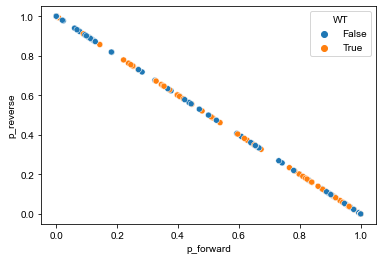

In [28]:
sns.scatterplot(x='p_forward',y='p_reverse',data=prob_dirs,hue='WT')

In [41]:
prob_dirs['entropy'] = -(np.log(prob_dirs['p_forward'] + 1e-20) * prob_dirs['p_forward'] + np.log(prob_dirs['p_reverse']+1e-20) * prob_dirs['p_reverse'])

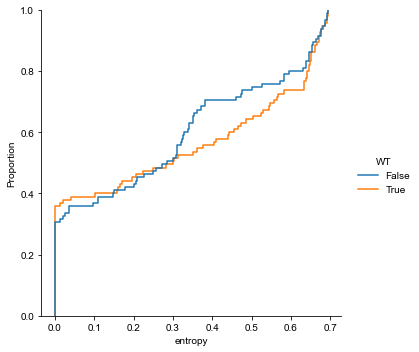

In [46]:
sns.displot(prob_dirs,x='entropy',hue='WT',kind="ecdf")

/Users/joshuagoldford/opt/miniconda3/envs/informatics3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

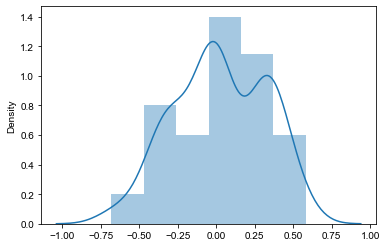

In [54]:
sns.distplot(prob_dirs[prob_dirs['WT']]['entropy'].values - prob_dirs[~prob_dirs['WT']]['entropy'].values)

In [49]:
from scipy.stats import ranksums

In [50]:
x = prob_dirs[prob_dirs['WT']]['entropy'].values
y = prob_dirs[~prob_dirs['WT']]['entropy'].values
ranksums(x,y)

RanksumsResult(statistic=0.3337650513648072, pvalue=0.7385568575298014)

In [26]:
nad_lethal = []
nadp_lethal = []

for idx,row in frr.iterrows():
    prob_j = prob_dirs[prob_dirs.reactions == idx]
    prob_lethal_nad = prob_j[prob_j['coenzyme'] == 'NAD']['p_forward'] * row.loc['NAD'].loc['F'] + prob_j[prob_j['coenzyme'] == 'NAD']['p_reverse'] * row.loc['NAD'].loc['B']
    
    prob_lethal_nadp = prob_j[prob_j['coenzyme'] == 'NADP']['p_forward'] * row.loc['NADP'].loc['F'] + prob_j[prob_j['coenzyme'] == 'NADP']['p_reverse'] * row.loc['NADP'].loc['B']
    nad_lethal.append(prob_lethal_nad.tolist()[0])
    nadp_lethal.append(prob_lethal_nadp.tolist()[0])
    
    

In [32]:
prob_dirs[['reactions','wt_coenzyme']].drop_duplicates().set_index('reactions')

,wt_coenzyme
reactions,
5DGLCNR,NADP
ABUTD,NAD
AGPR,NADP
AKGDH,NAD
ALCD19,NAD
...,...
UAPGR,NADP
UDPGD,NAD
UDPGDC,NAD


In [33]:
prob_dirs

,reactions,wt_coenzyme,coenzyme,p_forward,p_reverse
0,5DGLCNR,NADP,NADP,0.967,0.033
1,5DGLCNR,NADP,NAD,0.637,0.363
2,ABUTD,NAD,NAD,1.000,0.000
3,ABUTD,NAD,NADP,0.993,0.007
4,AGPR,NADP,NADP,0.008,0.992
...,...,...,...,...,...
185,UDPGDC,NAD,NADP,1.000,0.000
186,URDGLYCD,NAD,NAD,0.808,0.192
187,URDGLYCD,NAD,NADP,0.519,0.481
188,XAND,NAD,NAD,0.976,0.024


In [27]:
pl = pd.DataFrame({'p(lethal|NAD)': nad_lethal ,'p(lethal|NADP)': nadp_lethal },index=frr.index)

In [36]:
pl = pl.join(prob_dirs[['reactions','wt_coenzyme']].drop_duplicates().set_index('reactions'))

<AxesSubplot:xlabel='p(lethal|NAD)', ylabel='p(lethal|NADP)'>

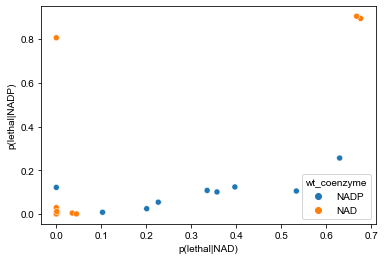

In [40]:
sns.scatterplot(x='p(lethal|NAD)',y='p(lethal|NADP)',data=pl,hue='wt_coenzyme')

In [48]:
pl[pl['p(lethal|NAD)'] + pl['p(lethal|NADP)']   > 0.1].sort_values('wt_coenzyme')

,p(lethal|NAD),p(lethal|NADP),wt_coenzyme
reaction,,,
HISTD,0.000000,0.806256,NAD
IPMD,0.676857,0.894845,NAD
PERD,0.667893,0.904799,NAD
AGPR,0.102850,0.007690,NADP
APRAUR,0.201066,0.023889,NADP
ASAD,0.630074,0.255812,NADP
DHDPRy,0.226781,0.053812,NADP
DXPRIi,0.397156,0.123427,NADP
ICDHyr,0.000000,0.121329,NADP


<AxesSubplot:xlabel='p(lethal|NAD)', ylabel='p(lethal|NADP)'>

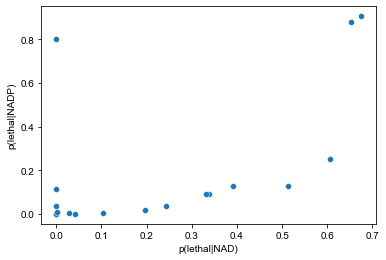

In [20]:
sns.scatterplot(x='p(lethal|NAD)',y='p(lethal|NADP)',data=pl)

In [24]:
pl.sort_values('p(lethal|NAD)')

,p(lethal|NAD),p(lethal|NADP)
reaction,,
GGGABADr,0.000000,0.000000
GHBDHx,0.000000,0.000000
GLUDy,0.000000,0.000000
GLUSy,0.000000,0.000000
GLYCDx,0.000000,0.000000
...,...,...
DXPRIi,0.392179,0.129399
P5CR,0.512719,0.126015
ASAD,0.605190,0.251831


In [1]:
#sns.displot(pl['p(lethal|NAD)'] - pl['p(lethal|NADP)'])
sns.displot(x='p(lethal|NAD)',y='p(lethal|NADP)',data=pl,)

NameError: name 'sns' is not defined

In [128]:
labels = ['PC' + str(x[0]) + ' [' + str(round(x[1],2)*100)+'%]' for x in list(zip(range(1,3),pca.explained_variance_ratio_))]

In [130]:
pdf = pd.DataFrame(pca.transform(X),columns = labels,index=dfn.T.index)

In [135]:
pdf = pd.DataFrame(pca.transform(X),columns = labels,index=dfn.T.index)

z = pd.DataFrame(dfn.mean(),columns = ['mean_ngrowth_rate'])
z2 = pd.DataFrame(dfn.min(),columns = ['min_ngrowth_rate'])
pdf['gene'] = [x.split('_')[0] for x in pdf.index.get_level_values(0)]
pdf['coenzyme'] = [x.split('_')[1] for x in pdf.index.get_level_values(0)]
pdf['direction'] = [x.split('_')[2] for x in pdf.index.get_level_values(0)]
pdf = pdf.join(z).join(z2)

,PC1 [91.0%],PC2 [7.000000000000001%],gene,coenzyme,direction,mean_ngrowth_rate,min_ngrowth_rate
PGCD_NADP_F,-173.783845,-22.651543,PGCD,NADP,F,0.991488,-16.551616
KARA1_NAD_B,-173.656250,-22.515988,KARA1,NAD,B,1.002189,-43.231863
PDH_NADP_R,-170.983422,-24.752036,PDH,NADP,R,1.019639,-19.185398
HISTD_NAD_B,-194.868541,-12.084450,HISTD,NAD,B,0.000000,0.000000
G6PDH2r_NADP_R,-173.849084,-22.779248,G6PDH2r,NADP,R,0.988611,-23.640029
...,...,...,...,...,...,...,...
PDH_NADP_B,-174.765322,-22.350268,PDH,NADP,B,0.939422,-22.004470
TAGURr_NAD_B,-173.852865,-22.476207,TAGURr,NAD,B,0.989393,-26.053451
FADRx_NADP_R,-137.485918,-40.013039,FADRx,NADP,R,1.015885,-25.037236
LALDO2x_NAD_B,-173.857303,-22.648973,LALDO2x,NAD,B,0.990330,-23.924105


In [269]:
#sns.scatterplot(x=labels[0],y=labels[1],data=pdf,hue='direction',size='mean_ngrowth_rate')

In [270]:
#sns.scatterplot(x=labels[0],y='mean_ngrowth_rate',data=pdf)

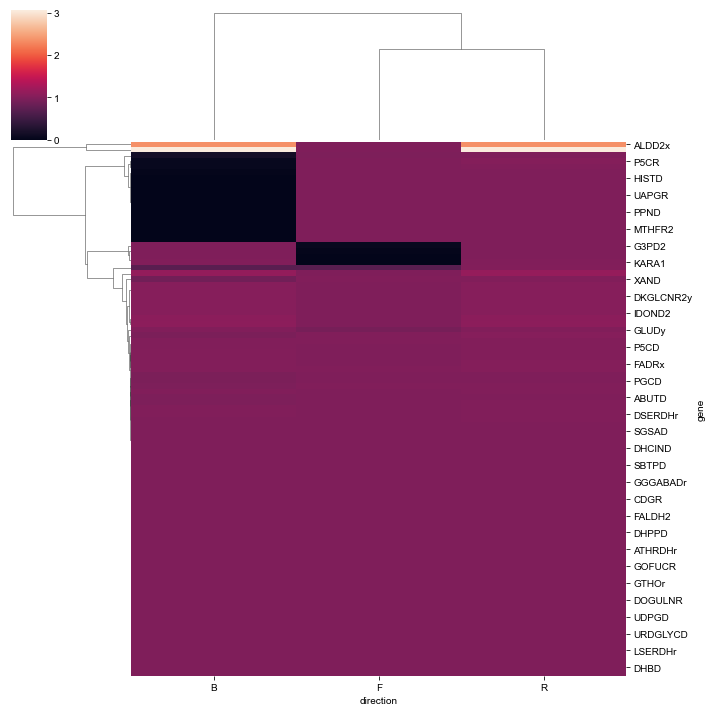

In [139]:
sns.clustermap(pdf.pivot_table(index='gene',columns=['direction'],values='mean_ngrowth_rate'))

In [146]:
(dfn < 1e-3).sum().sort_values()

KARA1_NADP_R           0
ME1_NAD_B            816
ALDD2x_NAD_B         817
ATHRDHr_NADP_F       824
G6PDH2r_NAD_F        828
                   ...  
HISTD_NADP_B      111157
ASAD_NAD_F        111157
IPMD_NADP_B       111157
IPMD_NAD_B        111157
KARA1_NAD_F       111157
Length: 570, dtype: int64

In [147]:
e = (dfn < 1e-3).sum()

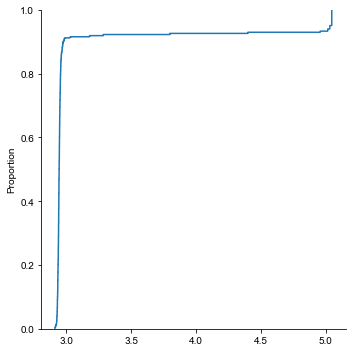

In [153]:
sns.displot(e.apply(np.log10),kind='ecdf')

In [160]:
zg = pd.DataFrame([x.split('_') for  x in e[e > 1e4].index.tolist()],columns = ['gene','coenzyme','direction'])

In [162]:
zg.sort_values('gene')

,gene,coenzyme,direction
32,AGPR,NADP,F
35,AGPR,NAD,F
5,APRAUR,NADP,B
6,APRAUR,NAD,B
24,ASAD,NADP,F
10,ASAD,NAD,F
8,DHDPRy,NAD,B
15,DHDPRy,NADP,B
3,DXPRIi,NAD,B
23,DXPRIi,NADP,B


In [166]:
len(zg.gene.unique())

21

In [167]:
zg.gene.unique()

array(['HISTD', 'ICDHyr', 'GCALDD', 'DXPRIi', 'SULR', 'APRAUR', 'DHDPRy',
       'ASAD', 'IPMD', 'GAPD', 'MTHFR2', 'PDX5PS', 'SHCHD2', 'PPND',
       'KARA2', 'G3PD2', 'PERD', 'UAPGR', 'P5CR', 'AGPR', 'KARA1'],
      dtype=object)

In [169]:
gs = pd.read_csv('../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')

In [227]:
essential = gs[gs.reaction.isin(rxn_w_zero)].gene.unique()

In [235]:
len(list(set(rxn_w_zero)))

48

In [229]:
cofactory_ecoli = pd.read_csv('../assets/structure/cofactory_results.csv')

In [236]:
cofactory_ecoli['essential_alo'] = cofactory_ecoli.gene.isin(essential)

<AxesSubplot:xlabel='nad', ylabel='nadp'>

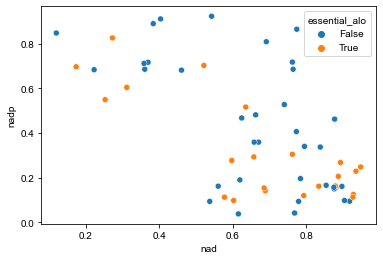

In [259]:
sns.scatterplot(x='nad',y='nadp',hue='essential_alo',data=cofactory_ecol_sub)

In [245]:
cofactory_ecoli['score'] = np.abs(np.log10(cofactory_ecoli.nad / cofactory_ecoli.nadp))

In [258]:
cofactory_ecol_sub = cofactory_ecoli[cofactory_ecoli['coenzyme'].isin(['NAD/NADP','NAD','NADP'])]

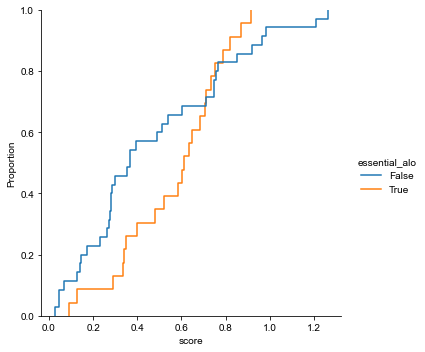

In [260]:
sns.displot(cofactory_ecol_sub,x='score',hue='essential_alo',kind='ecdf')

In [249]:
from scipy.stats import kstest,ranksums

In [261]:
x = cofactory_ecol_sub[cofactory_ecol_sub['essential_alo']]['score'].values
y = cofactory_ecol_sub[~cofactory_ecol_sub['essential_alo']]['score'].values


In [263]:
kstest(x,y)

KstestResult(statistic=0.3416149068322981, pvalue=0.05514350752777941)

In [198]:
media = pd.read_csv('../assets/media.C180N93E7.txt',sep='\t',index_col=0)

In [202]:
media.nitrogen.unique()

array(['EX_23camp_e', 'EX_23ccmp_e', 'EX_23cgmp_e', 'EX_23cump_e',
       'EX_23dappa_e', 'EX_3amp_e', 'EX_3cmp_e', 'EX_3gmp_e', 'EX_3ump_e',
       'EX_4abut_e', 'EX_LalaDgluMdapDala_e', 'EX_LalaDgluMdap_e',
       'EX_LalaDglu_e', 'EX_LalaLglu_e', 'EX_acgam1p_e', 'EX_acgam_e',
       'EX_acmana_e', 'EX_acmum_e', 'EX_acnam_e', 'EX_ade_e', 'EX_adn_e',
       'EX_agm_e', 'EX_ala__D_e', 'EX_ala__L_e', 'EX_alaala_e',
       'EX_alltn_e', 'EX_amp_e', 'EX_anhgm_e', 'EX_arg__L_e',
       'EX_asn__L_e', 'EX_asp__L_e', 'EX_cgly_e', 'EX_chtbs_e',
       'EX_cmp_e', 'EX_csn_e', 'EX_cynt_e', 'EX_cys__D_e', 'EX_cys__L_e',
       'EX_cytd_e', 'EX_dad_2_e', 'EX_damp_e', 'EX_dcmp_e', 'EX_dcyt_e',
       'EX_dgmp_e', 'EX_dgsn_e', 'EX_dimp_e', 'EX_din_e', 'EX_dopa_e',
       'EX_dump_e', 'EX_duri_e', 'EX_etha_e', 'EX_g3pe_e', 'EX_g3ps_e',
       'EX_gam6p_e', 'EX_gam_e', 'EX_gln__L_e', 'EX_glu__L_e', 'EX_gly_e',
       'EX_gmp_e', 'EX_gsn_e', 'EX_gthrd_e', 'EX_gua_e', 'EX_hxan_e',
       'EX_imp_e', 'E

In [ ]:
nsources = []